📈 Próg anomalii (95. percentyl): 0.0039


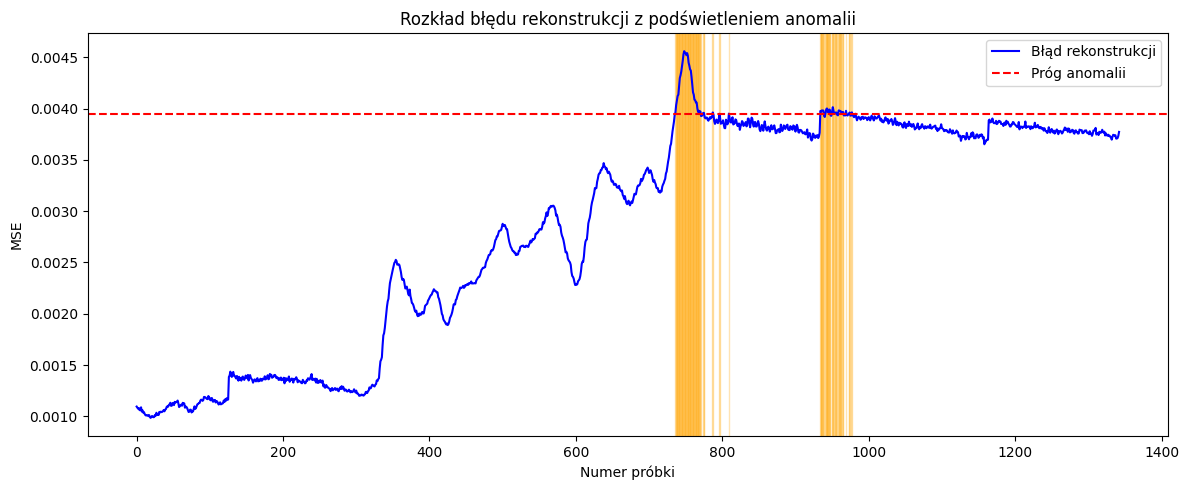

✅ Zapisano raport do pliku: anomaly_results_on_test_data/weld_anomaly_report.csv


In [6]:
import os
import glob
import csv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# === KONFIGURACJA ===
IMAGE_DIR = "output_rois/test_roi_weld"   # folder z danymi do testu
# IMAGE_DIR = "output_rois/test_roi_arc"
MODEL_PATH = "./models/weld_autoencoder_test.pth"            # ścieżka do zapisanego modelu
# MODEL_PATH = "arc_autoencoder.pth"   
OUTPUT_DIR = "anomaly_results_on_test_data"
os.makedirs(OUTPUT_DIR, exist_ok=True)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMAGE_SIZE = (64, 64)

# === TRANSFORMACJA OBRAZÓW ===
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()  # [0,1]
])

# === DATASET ===
class WeldDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.files = sorted(glob.glob(os.path.join(folder, "*.jpg")))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx])
        if self.transform:
            img = self.transform(img)
        return img, os.path.basename(self.files[idx])

# === STRUKTURA AUTOENCODERA ===
class ConvAutoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 8, 3, stride=2, padding=1), torch.nn.ReLU(),
            torch.nn.Conv2d(8, 16, 3, stride=2, padding=1), torch.nn.ReLU(),
            torch.nn.Conv2d(16, 32, 3, stride=2, padding=1), torch.nn.ReLU()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1), torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1), torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

# === WCZYTANIE MODELU ===
model = ConvAutoencoder().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# === DETEKCJA ANOMALII ===
dataset = WeldDataset(IMAGE_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

errors = []
filenames = []

with torch.no_grad():
    for img, fname in dataloader:
        img = img.to(DEVICE)
        recon = model(img)
        loss = F.mse_loss(recon, img).item()
        errors.append(loss)
        filenames.append(fname[0])

# === PROG ANOMALII ===
threshold = np.percentile(errors, 95)
print(f"📈 Próg anomalii (95. percentyl): {threshold:.4f}")

# === ZAPIS HEATMAP DLA ANOMALII ===
for i, (error, fname) in enumerate(zip(errors, filenames)):
    if error < threshold:
        continue

    img = dataset[i][0]
    input_tensor = img.unsqueeze(0).to(DEVICE)
    recon = model(input_tensor).cpu().squeeze()
    diff = torch.abs(img.squeeze() - recon)

    plt.imshow(diff.detach().cpu().numpy(), cmap='hot')
    plt.title(f"Anomalia: {fname}\nMSE: {error:.4f}")
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"anomaly_{fname}.png"))
    plt.close()

# === WYKRES BŁĘDU Z PODŚWIETLENIEM ANOMALII ===
errors_np = np.array(errors)
x = np.arange(len(errors_np))
anomaly_indices = np.where(errors_np > threshold)[0]

plt.figure(figsize=(12, 5))
plt.plot(x, errors_np, label='Błąd rekonstrukcji', color='blue')
plt.axhline(y=threshold, color='red', linestyle='--', label='Próg anomalii')
for idx in anomaly_indices:
    plt.axvspan(idx - 0.5, idx + 0.5, color='orange', alpha=0.3)
plt.title("Rozkład błędu rekonstrukcji z podświetleniem anomalii")
plt.xlabel("Numer próbki")
plt.ylabel("MSE")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "highlighted_anomalies.png"))
plt.show()

# === ZAPIS DO CSV ===
csv_path = os.path.join(OUTPUT_DIR, "weld_anomaly_report.csv")
with open(csv_path, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["filename", "mse", "anomaly"])
    for fname, err in zip(filenames, errors):
        writer.writerow([fname, f"{err:.6f}", int(err > threshold)])

print(f"✅ Zapisano raport do pliku: {csv_path}")

📈 Próg anomalii (95. percentyl max diff): 0.3429


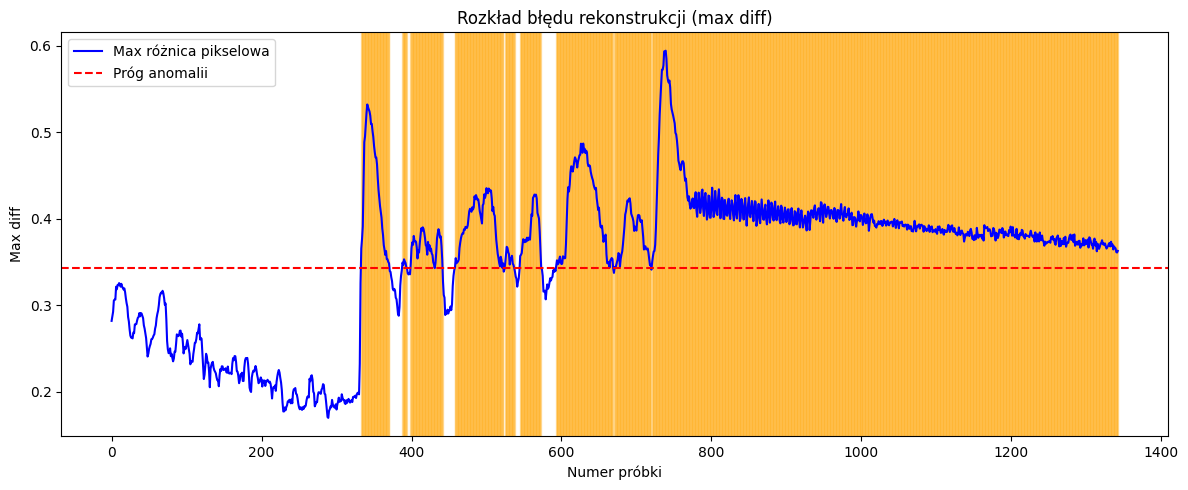

✅ Zapisano raport do pliku: anomaly_results_on_test_data/weld_anomaly_report_max_diff.csv


In [12]:
# === DETEKCJA ANOMALII Z MAX DIFF ===
import os
import glob
import csv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# === KONFIGURACJA ===
IMAGE_DIR = "output_rois/test_roi_weld"
MODEL_PATH = "./models/weld_autoencoder_test.pth"
OUTPUT_DIR = "anomaly_results_on_test_data"
os.makedirs(OUTPUT_DIR, exist_ok=True)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMAGE_SIZE = (64, 64)

# === TRANSFORMACJA OBRAZÓW ===
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()  # [0,1]
])

# === DATASET ===
class WeldDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.files = sorted(glob.glob(os.path.join(folder, "*.jpg")))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx])
        if self.transform:
            img = self.transform(img)
        return img, os.path.basename(self.files[idx])

# === STRUKTURA AUTOENCODERA ===
class ConvAutoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 8, 3, stride=2, padding=1), torch.nn.ReLU(),
            torch.nn.Conv2d(8, 16, 3, stride=2, padding=1), torch.nn.ReLU(),
            torch.nn.Conv2d(16, 32, 3, stride=2, padding=1), torch.nn.ReLU()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1), torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1), torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

# === WCZYTANIE MODELU ===
model = ConvAutoencoder().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# === DETEKCJA ANOMALII ===
dataset = WeldDataset(IMAGE_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

errors = []
filenames = []

with torch.no_grad():
    for img, fname in dataloader:
        img = img.to(DEVICE)
        recon = model(img)
        diff = torch.abs(recon - img)
        max_diff = diff.max().item()
        errors.append(max_diff)
        filenames.append(fname[0])

# === PROG ANOMALII ===
threshold = np.percentile(errors, 30)  # możesz dostosować np. na 90 lub ręcznie
print(f"📈 Próg anomalii (95. percentyl max diff): {threshold:.4f}")

# === ZAPIS HEATMAP DLA ANOMALII ===
for i, (error, fname) in enumerate(zip(errors, filenames)):
    if error < threshold:
        continue

    img = dataset[i][0]
    input_tensor = img.unsqueeze(0).to(DEVICE)
    recon = model(input_tensor).cpu().squeeze()
    diff = torch.abs(img.squeeze() - recon)

    plt.imshow(diff.detach().cpu().numpy(), cmap='hot')
    plt.title(f"Anomalia: {fname}\nmax diff: {error:.4f}")
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"anomaly_{fname}.png"))
    plt.close()

# === WYKRES BŁĘDU Z PODŚWIETLENIEM ANOMALII ===
errors_np = np.array(errors)
x = np.arange(len(errors_np))
anomaly_indices = np.where(errors_np > threshold)[0]

plt.figure(figsize=(12, 5))
plt.plot(x, errors_np, label='Max różnica pikselowa', color='blue')
plt.axhline(y=threshold, color='red', linestyle='--', label='Próg anomalii')
for idx in anomaly_indices:
    plt.axvspan(idx - 0.5, idx + 0.5, color='orange', alpha=0.3)
plt.title("Rozkład błędu rekonstrukcji (max diff)")
plt.xlabel("Numer próbki")
plt.ylabel("Max diff")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "highlighted_anomalies_max_diff.png"))
plt.show()

# === ZAPIS DO CSV ===
csv_path = os.path.join(OUTPUT_DIR, "weld_anomaly_report_max_diff.csv")
with open(csv_path, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["filename", "max_diff", "anomaly"])
    for fname, err in zip(filenames, errors):
        writer.writerow([fname, f"{err:.6f}", int(err > threshold)])

print(f"✅ Zapisano raport do pliku: {csv_path}")


📏 Wczytany stały próg anomalii: 0.347504


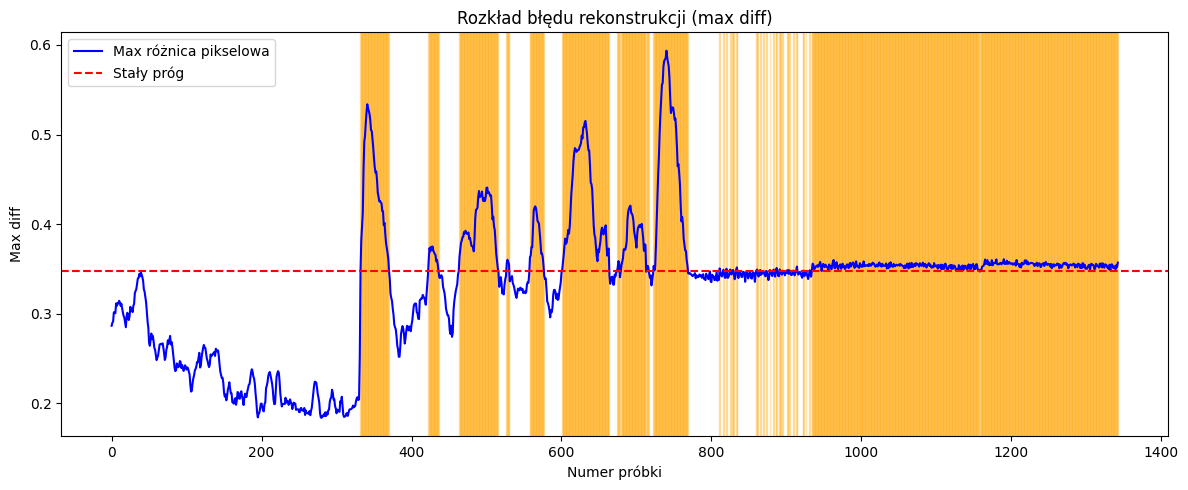

✅ Zapisano raport do pliku: anomaly_results_on_test_data/weld_anomaly_report_max_diff.csv


In [14]:
# === DETEKCJA ANOMALII ZE STAŁYM PROGIEM ===
import os
import glob
import csv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# === KONFIGURACJA ===
IMAGE_DIR = "output_rois/test_roi_weld"
MODEL_PATH = "./models/weld_autoencoder_test.pth"
THRESHOLD_PATH = "./models/weld_threshold.txt"
OUTPUT_DIR = "anomaly_results_on_test_data"
os.makedirs(OUTPUT_DIR, exist_ok=True)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMAGE_SIZE = (64, 64)

# === TRANSFORMACJA OBRAZÓW ===
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()
])

# === DATASET ===
class WeldDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.files = sorted(glob.glob(os.path.join(folder, "*.jpg")))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx])
        if self.transform:
            img = self.transform(img)
        return img, os.path.basename(self.files[idx])

# === STRUKTURA AUTOENCODERA ===
class ConvAutoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 8, 3, stride=2, padding=1), torch.nn.ReLU(),
            torch.nn.Conv2d(8, 16, 3, stride=2, padding=1), torch.nn.ReLU(),
            torch.nn.Conv2d(16, 32, 3, stride=2, padding=1), torch.nn.ReLU()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1), torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1), torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

# === WCZYTANIE MODELU I PROGU ===
model = ConvAutoencoder().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

with open(THRESHOLD_PATH, 'r') as f:
    threshold = float(f.read().strip())
print(f"📏 Wczytany stały próg anomalii: {threshold:.6f}")

# === DETEKCJA ANOMALII ===
dataset = WeldDataset(IMAGE_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

errors = []
filenames = []

with torch.no_grad():
    for img, fname in dataloader:
        img = img.to(DEVICE)
        recon = model(img)
        diff = torch.abs(recon - img)
        max_diff = diff.max().item()
        errors.append(max_diff)
        filenames.append(fname[0])

# === ZAPIS HEATMAP DLA ANOMALII ===
for i, (error, fname) in enumerate(zip(errors, filenames)):
    if error < threshold:
        continue

    img = dataset[i][0]
    input_tensor = img.unsqueeze(0).to(DEVICE)
    recon = model(input_tensor).cpu().squeeze()
    diff = torch.abs(img.squeeze() - recon)

    plt.imshow(diff.detach().cpu().numpy(), cmap='hot')
    plt.title(f"Anomalia: {fname}\nmax diff: {error:.4f}")
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"anomaly_{fname}.png"))
    plt.close()

# === WYKRES BŁĘDU Z PODŚWIETLENIEM ANOMALII ===
errors_np = np.array(errors)
x = np.arange(len(errors_np))
anomaly_indices = np.where(errors_np > threshold)[0]

plt.figure(figsize=(12, 5))
plt.plot(x, errors_np, label='Max różnica pikselowa', color='blue')
plt.axhline(y=threshold, color='red', linestyle='--', label='Stały próg')
for idx in anomaly_indices:
    plt.axvspan(idx - 0.5, idx + 0.5, color='orange', alpha=0.3)
plt.title("Rozkład błędu rekonstrukcji (max diff)")
plt.xlabel("Numer próbki")
plt.ylabel("Max diff")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "highlighted_anomalies_max_diff.png"))
plt.show()

# === ZAPIS DO CSV ===
csv_path = os.path.join(OUTPUT_DIR, "weld_anomaly_report_max_diff.csv")
with open(csv_path, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["filename", "max_diff", "anomaly"])
    for fname, err in zip(filenames, errors):
        writer.writerow([fname, f"{err:.6f}", int(err > threshold)])

print(f"✅ Zapisano raport do pliku: {csv_path}")


📈 Próg anomalii (95. percentyl): 0.0019


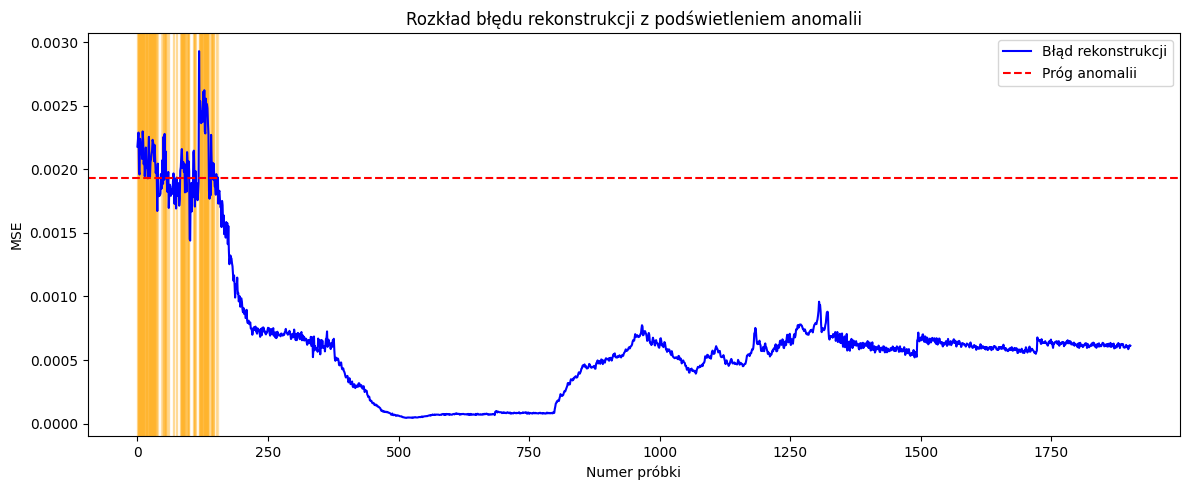

✅ Zapisano raport do pliku: anomaly_results_on_test_data/arc_anomaly_report.csv


In [2]:
import os
import glob
import csv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# === KONFIGURACJA ===
# IMAGE_DIR = "output_rois/test_roi_weld"   # folder z danymi do testu
IMAGE_DIR = "output_rois/test_roi_arc"
# MODEL_PATH = "autoencoder.pth"            # ścieżka do zapisanego modelu
MODEL_PATH = "./models/arc_autoencoder.pth"   
OUTPUT_DIR = "anomaly_results_on_test_data"
os.makedirs(OUTPUT_DIR, exist_ok=True)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMAGE_SIZE = (64, 64)

# === TRANSFORMACJA OBRAZÓW ===
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()  # [0,1]
])

# === DATASET ===
class WeldDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.files = sorted(glob.glob(os.path.join(folder, "*.jpg")))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx])
        if self.transform:
            img = self.transform(img)
        return img, os.path.basename(self.files[idx])

# === STRUKTURA AUTOENCODERA ===
class ConvAutoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 8, 3, stride=2, padding=1), torch.nn.ReLU(),
            torch.nn.Conv2d(8, 16, 3, stride=2, padding=1), torch.nn.ReLU(),
            torch.nn.Conv2d(16, 32, 3, stride=2, padding=1), torch.nn.ReLU()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1), torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1), torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

# === WCZYTANIE MODELU ===
model = ConvAutoencoder().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# === DETEKCJA ANOMALII ===
dataset = WeldDataset(IMAGE_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

errors = []
filenames = []

with torch.no_grad():
    for img, fname in dataloader:
        img = img.to(DEVICE)
        recon = model(img)
        loss = F.mse_loss(recon, img).item()
        errors.append(loss)
        filenames.append(fname[0])

# === PROG ANOMALII ===
threshold = np.percentile(errors, 95)
print(f"📈 Próg anomalii (95. percentyl): {threshold:.4f}")

# === ZAPIS HEATMAP DLA ANOMALII ===
for i, (error, fname) in enumerate(zip(errors, filenames)):
    if error < threshold:
        continue

    img = dataset[i][0]
    input_tensor = img.unsqueeze(0).to(DEVICE)
    recon = model(input_tensor).cpu().squeeze()
    diff = torch.abs(img.squeeze() - recon)

    plt.imshow(diff.detach().cpu().numpy(), cmap='hot')
    plt.title(f"Anomalia: {fname}\nMSE: {error:.4f}")
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"anomaly_{fname}.png"))
    plt.close()

# === WYKRES BŁĘDU Z PODŚWIETLENIEM ANOMALII ===
errors_np = np.array(errors)
x = np.arange(len(errors_np))
anomaly_indices = np.where(errors_np > threshold)[0]

plt.figure(figsize=(12, 5))
plt.plot(x, errors_np, label='Błąd rekonstrukcji', color='blue')
plt.axhline(y=threshold, color='red', linestyle='--', label='Próg anomalii')
for idx in anomaly_indices:
    plt.axvspan(idx - 0.5, idx + 0.5, color='orange', alpha=0.3)
plt.title("Rozkład błędu rekonstrukcji z podświetleniem anomalii")
plt.xlabel("Numer próbki")
plt.ylabel("MSE")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "highlighted_anomalies.png"))
plt.show()

# === ZAPIS DO CSV ===
csv_path = os.path.join(OUTPUT_DIR, "arc_anomaly_report.csv")
with open(csv_path, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["filename", "mse", "anomaly"])
    for fname, err in zip(filenames, errors):
        writer.writerow([fname, f"{err:.6f}", int(err > threshold)])

print(f"✅ Zapisano raport do pliku: {csv_path}")

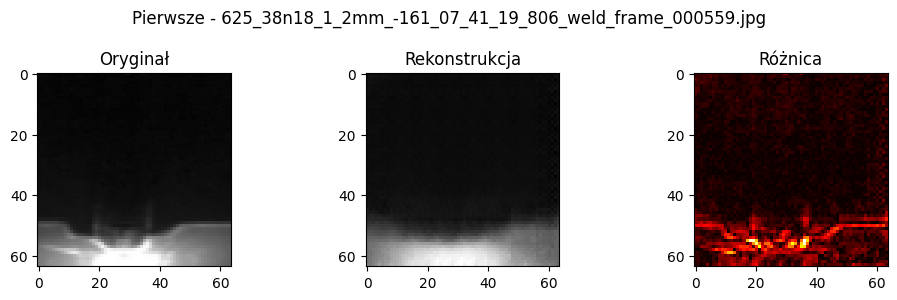

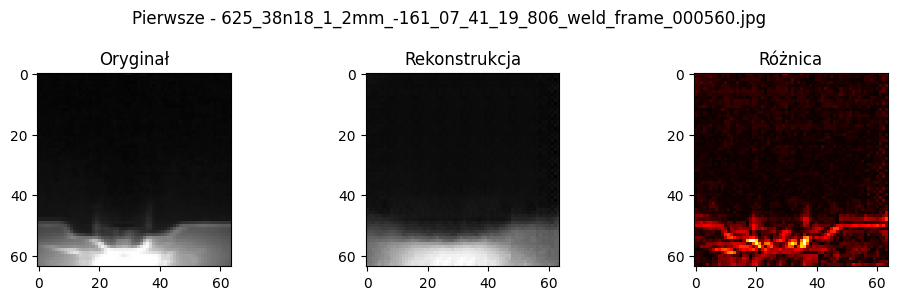

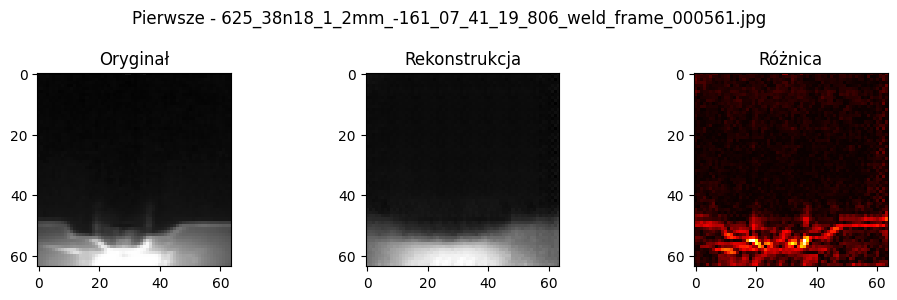

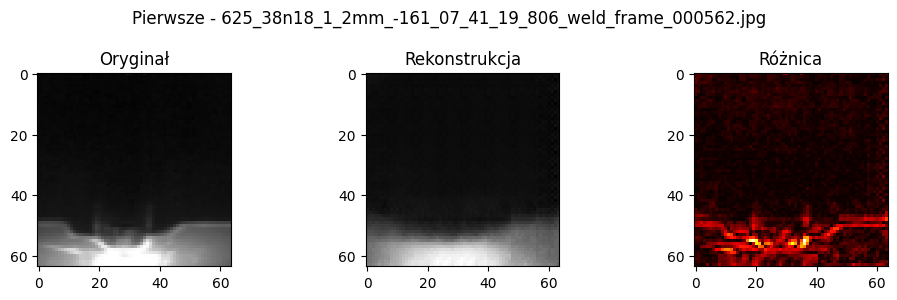

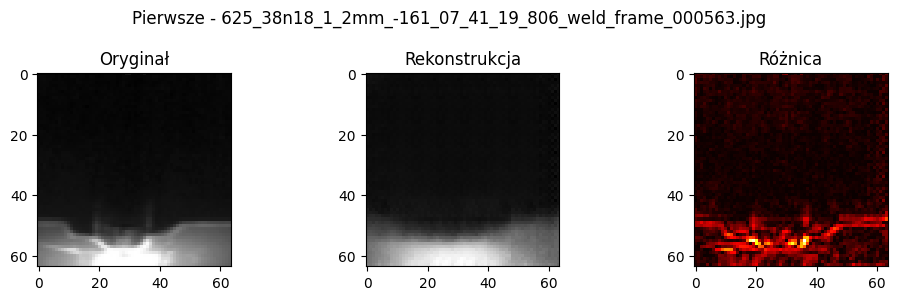

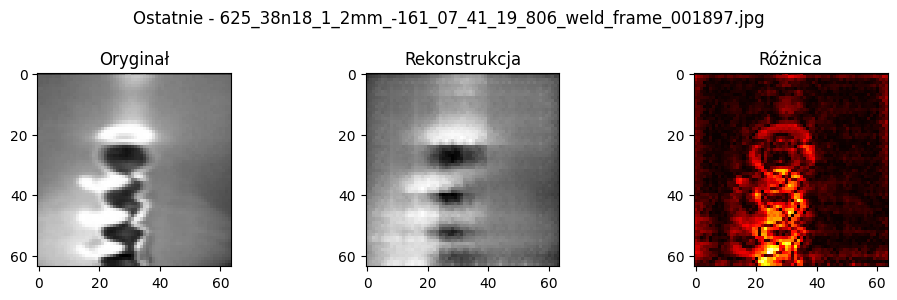

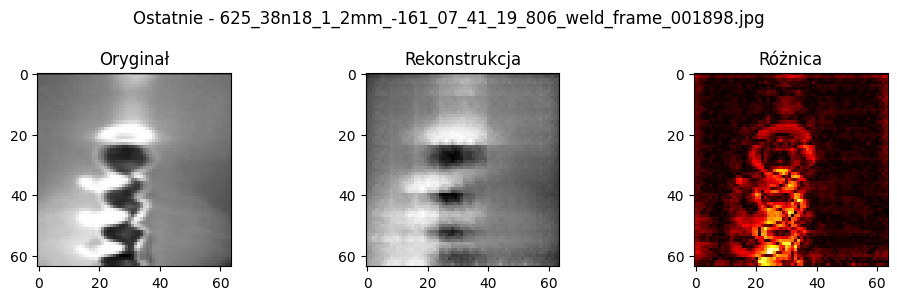

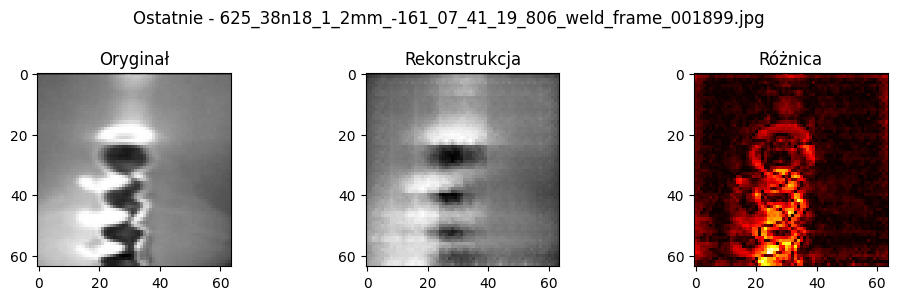

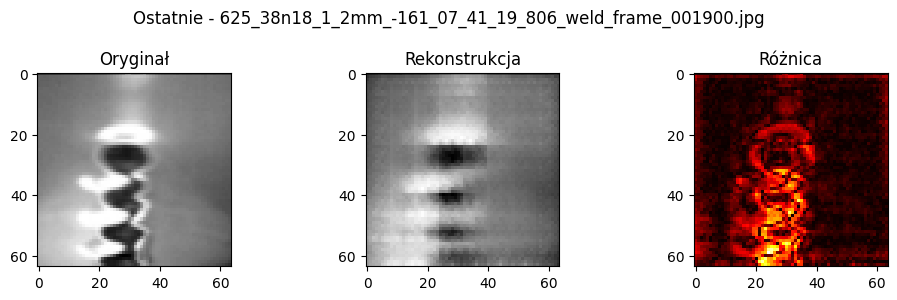

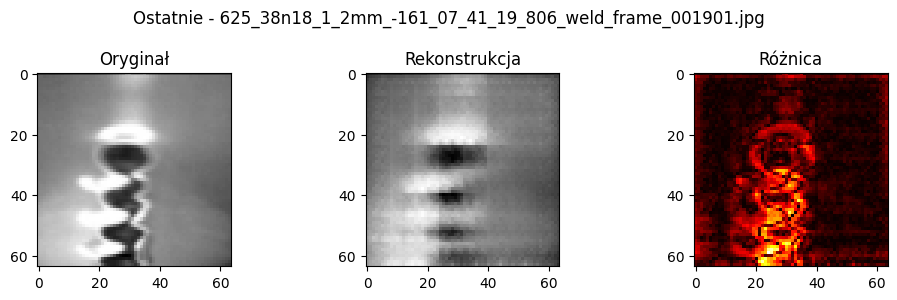

In [15]:
# === PODGLĄD REKONSTRUKCJI ===
model.eval()
with torch.no_grad():
    # Pierwsze 5 obrazów
    for i in range(5):
        img, fname = dataset[i]
        img_tensor = img.unsqueeze(0).to(DEVICE)
        recon = model(img_tensor).cpu().squeeze()
        diff = torch.abs(img.squeeze() - recon)

        plt.figure(figsize=(10, 3))
        plt.suptitle(f"Pierwsze - {fname}")
        plt.subplot(1, 3, 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title("Oryginał")
        plt.subplot(1, 3, 2)
        plt.imshow(recon, cmap='gray')
        plt.title("Rekonstrukcja")
        plt.subplot(1, 3, 3)
        plt.imshow(diff, cmap='hot')
        plt.title("Różnica")
        plt.tight_layout()
        plt.show()

    # Ostatnie 5 obrazów
    dataset_len = len(dataset)
    for i in range(dataset_len - 5, dataset_len):
        img, fname = dataset[i]
        img_tensor = img.unsqueeze(0).to(DEVICE)
        recon = model(img_tensor).cpu().squeeze()
        diff = torch.abs(img.squeeze() - recon)

        plt.figure(figsize=(10, 3))
        plt.suptitle(f"Ostatnie - {fname}")
        plt.subplot(1, 3, 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title("Oryginał")
        plt.subplot(1, 3, 2)
        plt.imshow(recon, cmap='gray')
        plt.title("Rekonstrukcja")
        plt.subplot(1, 3, 3)
        plt.imshow(diff, cmap='hot')
        plt.title("Różnica")
        plt.tight_layout()
        plt.show()